In [1]:
!python --version
import os
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45373/status,
Dashboard: http://127.0.0.1:45373/status,Workers: 4
Total threads: 8,Total memory: 62.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44175,Workers: 4
Dashboard: http://127.0.0.1:45373/status,Total threads: 8
Started: Just now,Total memory: 62.53 GiB
Comm: tcp://127.0.0.1:39721,Total threads: 2
Dashboard: http://127.0.0.1:34275/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:41495,


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=10)

import scipy as scipy
from scipy import stats
import math
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import proplot as plot
import cartopy.crs as ccrs
import seaborn as sns

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import h5py
import scipy.io

In [3]:
# set the path to local folder other than github
login_name = os.getlogin()
### 1.4.1 Local path on PC
local_documents_path = f'/home/{login_name}/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = f'/home/{login_name}/OneDrive'

In [4]:
def label_pvalues(x):
    if x<0.001:
        return r'$\it{P}$<.001'
    elif x<0.01:
        return r'$\it{P}$<.01'
    elif x<0.05:
        return r'$\it{P}$<.05'
    elif x<0.1:
        return r'$\it{P}$<.1'
    elif x>=0.1:
        return r'$\it{P}$>.1'
    
from matplotlib.colors import Normalize
class FlatCenterNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, center=0, plateau_width=0.025, clip=False):
        self.center = center
        self.plateau_width = plateau_width
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Process input value(s)
        result, is_scalar = self.process_value(value)
        vmin, vmax = self.vmin, self.vmax
        # Map values in a piecewise linear fashion:
        # vmin --> 0, (center - plateau) --> 0.5, (center + plateau) --> 0.5, vmax --> 1
        mapped = np.ma.masked_array(np.interp(result, 
                    [vmin, self.center - self.plateau_width, self.center + self.plateau_width, vmax],
                    [0, 0.5, 0.5, 1]))
        if is_scalar:
            mapped = mapped[0]
        return mapped


In [5]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds04_gridded_coretop_tex.nc'
gridded_coretop_ds = xr.open_dataset(os.path.join(fpath,fname))
gridded_coretop_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    region_ID      (lon, lat) float64 ...
    tex_count      (lon, lat) float64 ...
    tex_median     (lon, lat) float64 ...
    tex_mean       (lon, lat) float64 ...
    tex_std        (lon, lat) float64 ...
    tex_residuals  (lon, lat) float64 ...
Attributes:
    title:             Gridded coretop TEX86 data
    long_name:         statistics of TEX86 for each grid cell with the same l...
    units:             TEX86 [unitless], thermocline-integrated T [degC], dep...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    processing_level:  Derived product
    history:           Computed from the global compilation of core-top GDGT ...
    references:        This study

In [6]:
### ocean properties dataset
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'
ocean_properties_ds = xr.open_dataset(os.path.join(fpath,fname),decode_times=False)
ocean_properties_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    no3_sf2tc_avg  (lat, lon) float32 ...
    no3_tc         (lat, lon) float32 ...
    t_sf2tc_avg    (lat, lon) float32 ...
    tc_depth       (lat, lon) float32 ...
    t_tc           (lat, lon) float32 ...
Attributes:
    title:             Calculated Ocean Properties: Nitrite and Temperature f...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    Conventions:       CF-1.7
    processing_level:  Derived product
    history:           (a) Nitrate: Calculated climatological annual means (1...
    references:        CMEMS, WOA23

In [7]:
fpath = fr'{local_github_path}/spreadsheets'
fname = 'ds03_processed_coretop_tex.csv'

coretop_df = pd.read_csv(f'{fpath}/{fname}')
coretop_df

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,region_ID,regionName,pred_tex,tex_residuals
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.0,6.0,31.651700,34.07330,562.0,0.662000,...,55.0,19.006910,21.589685,0.088246,0.003865,0.025728,NaN,NaN,0.593260,0.068740
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.0,8.0,-1.532700,-86.78520,2288.0,0.602873,...,25.0,20.861510,22.520248,4.094641,8.300386,5.318187,10.0,East Equatorial Pacific,0.603206,-0.000333
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.0,1.0,-3.710500,-81.11530,378.0,0.570000,...,15.0,20.730000,22.093159,3.517715,5.804398,4.208444,NaN,NaN,0.598641,-0.028641
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.0,1.0,-3.750200,-81.13580,379.0,0.572000,...,15.0,20.583000,22.041553,4.415240,7.112034,5.378340,NaN,NaN,0.598090,-0.026090
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.0,6.0,-3.969000,-81.31000,1024.0,0.599447,...,15.0,20.119310,21.319408,4.326240,6.462469,4.969550,10.0,East Equatorial Pacific,0.590371,0.009076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,RR02080,JET_RR_02080,AMD17_176_BC,NaN,NaN,NaN,69.600000,-65.40000,267.0,0.400000,...,10.0,-0.879210,-0.630935,3.086211,3.155563,3.107517,60.0,Baffin Bay,0.355749,0.044251
2078,RR02081,JET_RR_02081,AMD17_8.1_BC,NaN,NaN,NaN,69.410000,-64.40000,1054.0,0.322581,...,10.0,-0.841310,-0.534860,2.976617,3.043328,2.995078,60.0,Baffin Bay,0.356776,-0.034195
2079,RR02082,JET_RR_02082,AMD17_Disko_Fan_BC,NaN,NaN,NaN,67.970000,-59.49000,1012.0,0.375000,...,10.0,0.088910,0.324683,2.783790,2.829360,2.795761,60.0,Baffin Bay,0.365963,0.009037
2080,RR02083,JET_RR_02083,DSDP591_0-3cm_PC,PC,0.0,3.0,-31.584330,164.44867,2131.0,0.671171,...,65.0,19.653900,20.455896,0.494959,0.917937,0.575588,61.0,Tasman Sea,0.581141,0.090030


In [24]:
t_sf2tc_da = ocean_properties_ds['t_sf2tc_avg']
thermocline_nitrate_da = ocean_properties_ds['no3_sf2tc_avg']
thermocline_depth_da = ocean_properties_ds.tc_depth

In [22]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_coretop_published_130307.mat'

mat_cortop = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_cortop.keys())
print(mat_cortop['__header__'])

df_tmp = []
features = ['name','region','ref',
            'lat','lon','depth','d15N',]
for i in range(len(mat_cortop['ctop_pub'][0][0][0])):
    for feature in features:
        if ('name' in feature) or ('region' in feature) or ('ref' in feature):
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0][0]
            except:
                sel_feature = np.nan
        else:
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0]
            except:
                sel_feature = np.nan
        df_tmp.append(sel_feature)
        

### convert df_tmp into a dataframe with 7 columns
coretop_d15N_df = pd.DataFrame(np.reshape(df_tmp, (2176,7)),columns=features)
coretop_d15N_df

### covert datatype of columns
coretop_d15N_df = coretop_d15N_df.astype({'lat':float,'lon':float,'depth':float,'d15N':float})
coretop_d15N_df


dict_keys(['__header__', '__version__', '__globals__', 'ctop_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 20:13:16 2013'


,name,region,ref,lat,lon,depth,d15N
0,ODP 1228,Eastern Pacific,Agnihotri et al. (2006),-11.064167,-78.077833,273.0,5.3506
1,ODP 1229,Iberian Margin,Alt-Epping et al. (2007),38.634500,-9.454200,NaN,5.6000
2,ODP 1230,Iberian Margin,Alt-Epping et al. (2007),38.625000,-9.508300,102.0,5.8000
3,ODP 1231,Iberian Margin,Alt-Epping et al. (2007),38.692200,-9.260600,19.0,6.3000
4,ODP 1232,Iberian Margin,Alt-Epping et al. (2007),38.646110,-9.424170,54.0,6.1000
...,...,...,...,...,...,...,...
2171,EW0408-084 MC-7,Gulf of Alaska,Walinsky et al. (2009),59.530000,-144.130000,686.0,3.3000
2172,EW0408-091 MC-8,Gulf of Alaska,Walinsky et al. (2009),59.650000,-145.150000,198.0,2.5000
2173,EW0408-094 MC-8,Gulf of Alaska,Walinsky et al. (2009),60.660000,-147.710000,744.0,3.7000
2174,EW0408-097 MC-8,Gulf of Alaska,Walinsky et al. (2009),60.560000,-146.770000,401.0,4.2000


In [25]:
### gridded coretop d15N
mid_lat_array = thermocline_depth_da.lat.values
mid_lon_array = thermocline_depth_da.lon.values

coretop_d15N_df['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-lat).argmin()] for lat in coretop_d15N_df['lat']]
coretop_d15N_df['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-lon).argmin()] for lon in coretop_d15N_df['lon']]

features = ['match_lat','match_lon','d15N']
pregridded_coretop_d15N_df = coretop_d15N_df[features]
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.dropna().reset_index(drop=True)

new_features = ['d15N_count','d15N_median','d15N_mean','d15N_std']
agg_func_list = ['count','median','mean','std']
for i, new_feature in enumerate(features):
    pregridded_coretop_d15N_df[new_features[i]] = pregridded_coretop_d15N_df.groupby([
        'match_lat','match_lon'])['d15N'].transform(agg_func_list[i])
    
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.drop_duplicates(
    subset=['match_lat','match_lon'],keep='first').reset_index(drop=True)

coretop_gridded_d15N_da = xr.Dataset.from_dataframe(pregridded_coretop_d15N_df.set_index(['match_lat','match_lon']))
coretop_gridded_d15N_da = coretop_gridded_d15N_da.rename({'match_lon':'lon','match_lat':'lat'})
## nan mask
# coretop_gridded_d15N_da = coretop_gridded_d15N_da.where(coretop_gridded_d15N_da['d15N_count']>1)
coretop_gridded_d15N_da

    
### combine all dataarrays into a single dataset
SST_da = thermocline_depth_da
coretop_gridded_d15N_ds = xr.merge([SST_da,coretop_gridded_d15N_da]).drop_vars(['tc_depth','d15N'])
coretop_gridded_d15N_ds

<xarray.Dataset>
Dimensions:      (lat: 720, lon: 1440)
Coordinates:
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    d15N_count   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_median  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_mean    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

r2 score = 0.7639197678579358
best_window_size = 19


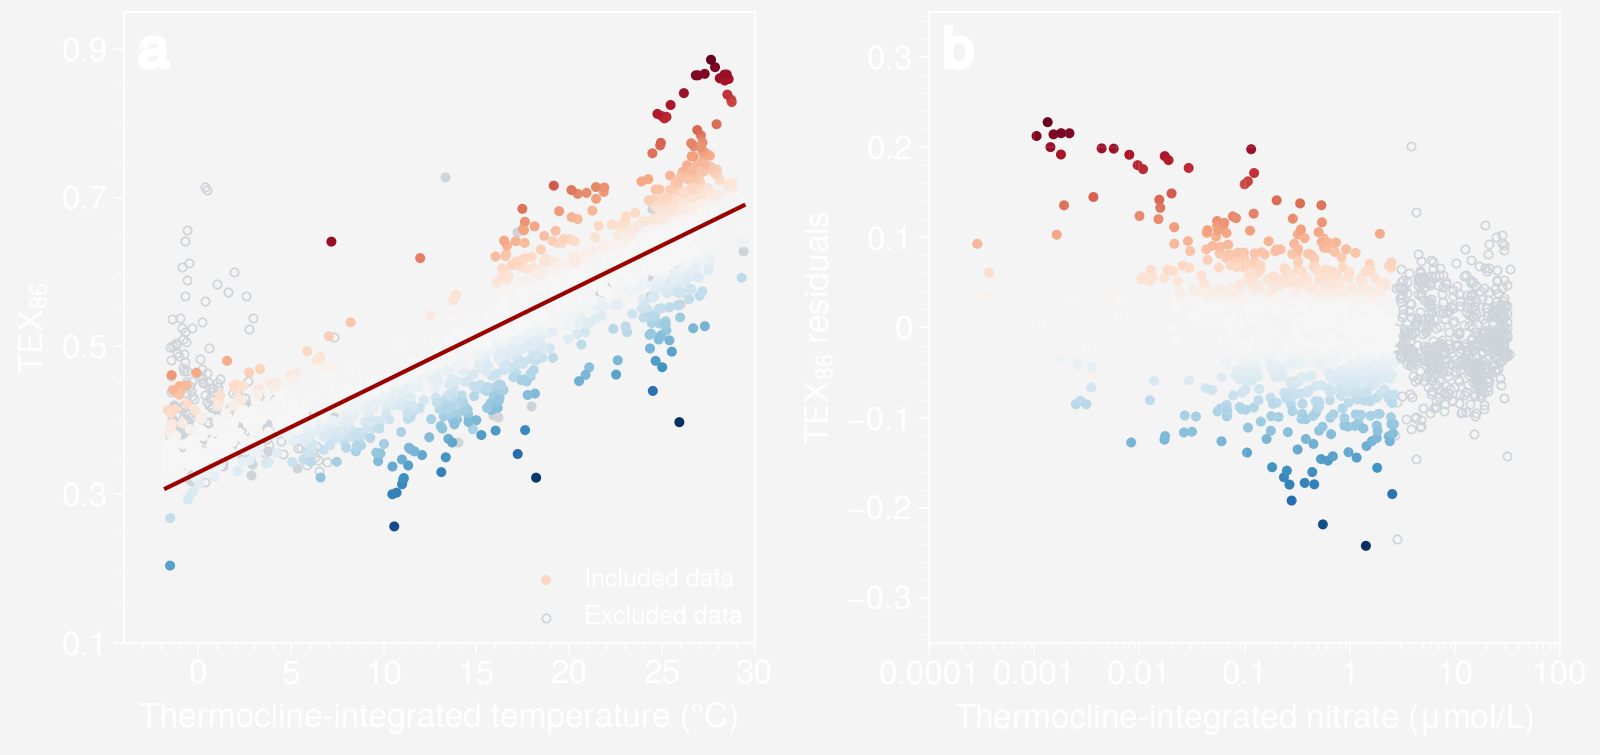

In [34]:
plot.rc['meta.color'] = 'w'
plot.rc['abc.color'] = 'w'
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']


fig, axs = plot.subplots(ncols=2,width=8,share=False)

axs.format(fontsize=12)

ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$'
)
plot_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg',
                                                  'tex_median']).reset_index()
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
plot_c = plot_data['tex_residuals']
norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,
           m='.',c=plot_c,
           norm=norm,
           cmap='burd',zorder=2,label='Included data')

plot_data = plot_coretop[plot_coretop['lat']>70].dropna(subset=['t_sf2tc_avg','tex_median'])
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
ax.scatter(plot_x,plot_y,
           m='.',c='none',
           mec='gray4',zorder=1,
           label='Excluded data')

plot_x = exclude_coretop['thermocline_T_depthIntegral']
plot_y = exclude_coretop['TEX86']
ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg','tex_median'])
reg_data2 = reg_data.dropna(subset=['t_sf2tc_avg','tex_median'])
ols_tex_thermoT_thisStudy = LinearRegression()
XX = reg_data2['t_sf2tc_avg']
yy = reg_data2['tex_median']
ols_tex_thermoT_thisStudy.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols_tex_thermoT_thisStudy.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['t_sf2tc_avg'],reg_data2['tex_median'])
### add linear regression equation as text in axs[0]
slope_text = f'{ols_tex_thermoT_thisStudy.coef_[0]:.3f}'
intercept_text = f'{ols_tex_thermoT_thisStudy.intercept_:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ T$_{{sf2tc}}$ + {intercept_text}'

print(f'r2 score = {ols_tex_thermoT_thisStudy.score(XX.values.reshape(-1,1),yy)}')
pval_label = label_pvalues(pval)
# ax.text(0.10,0.98,f'$\\rho$={rho:.2f}, {pval_label}\n(Gridded coretops; N={len(reg_data2)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='top')

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='lr',ncols=1,frameon=False,fontcolor='w')
ax.format(
        ylim=(0.1,0.95),
        yticks=np.arange(0.1,1,0.2),
        xlim=(-4,30),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=['no3_sf2tc_avg','tex_residuals'])
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
# ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
#         transform=ax.transAxes,
#         ha='right',va='top',
#         c='gray7')

sel_x_param = 'no3_sf2tc_avg'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### determine best window size
window_size = np.arange(5,101,1)
score_list = []
pval_list = []
for sel_window_size in window_size:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],sel_window_size)
        lowno3_threshold_tmp = 10**log_x[y_running_mean.idxmin()]
        reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold_tmp]
        rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
        score_list.append(rho)
        pval_list.append(pval)
best_window_size = window_size[np.argmin(score_list)]
# best_window_size = 100
print(f'best_window_size = {best_window_size}')
### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
# ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
lowno3_threshold = np.round(10**log_x[y_running_mean.idxmin()],decimals=1)
# ax.text(lowno3_threshold-0.1,0.99,f'{lowno3_threshold:.1f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
#         ha='right',va='top',
#         rotation=90)
# ax.plot(10**log_x,y_running_mean,c='k',lw=1)

plot_x = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_x_param]
plot_y = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_y_param]

norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,marker='.',color=plot_y,
           norm=norm,
           cmap='burd',label='Coretops')


plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=[sel_x_param,sel_y_param])
plot_x_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_x_param]
plot_y_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_y_param]
ax.scatter(plot_x_exclude,plot_y_exclude,
            marker='.',color='none',
            mec='gray4',
            label='Excluded data',zorder=0)


reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
# ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
#         label='TEX residuals')

### print regression equation
slope_text = f'{ols.params[1]:.3f}'
intercept_text = f'{ols.params[0]:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ log$_{{10}}$[Nitrate] + {intercept_text}'

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
# ax.text(0.02,0.02,
#         f'$\\rho$={rho:.2f}, {pval_label}\n(data with nitrate < {lowno3_threshold:.1f} $\mu$mol/L; N={len(reg_data)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='bottom')



ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    xgridminor=True,
    ylim=(-0.35,0.35),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
)
#########################################################################################
axs.format(abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20,
                                                    'abc.weight':'normal',},
           facecolor='none',
           gridcolor='w')


fpath = fr'{local_github_path}/figures/'
fname = 'nitrate_effect_global_plot_highlight.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,transparent=True)

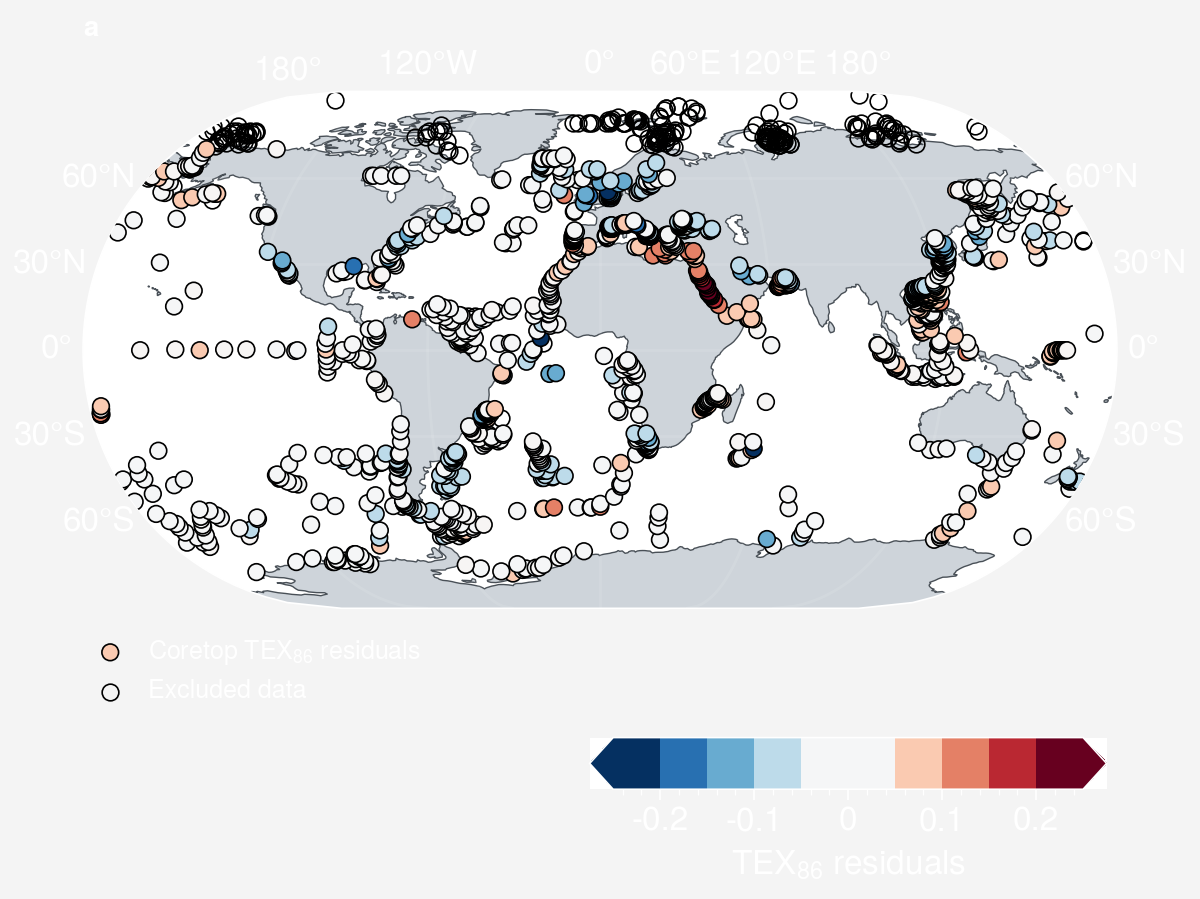

In [35]:
plot.rc['meta.color'] = 'w'


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']


fig, axs = plot.subplots(proj='eck3',width=6)

ax = axs[0]
ax.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='lr', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlines=30,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray7',
        coastlinewidth=0.5,
        coastzorder=1,
        labelsize=12)
# ##### plot a contour line of thermocline-integrated nitrate at lowno3_threshold μM
# m = thermocline_nitrate_da.plot.contourf(ax=ax,levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
#                                         cmap='matter',alpha=0.8,
#                                         add_colorbar=False,robust=True,
#                                         label=None,rasterized=True)

# axins1 = inset_axes(
#     ax,
#     width="50%",
#     height="10%",
#     loc="lower right",
#     bbox_to_anchor=(-0.01,-0.05,1,1),
#     bbox_transform=ax.transAxes,
#     borderpad=0,
# )

# axins1.patch.set_alpha(0)
# cbar = fig.colorbar(m,
#              cax=axins1,
#              orientation="horizontal",)
# cbar.set_label('Thermocline-integrated nitrate ($\mu$mol/L)', size=12)
# cbar.ax.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])
# cbar.ax.tick_params(labelsize=12,labelcolor='w')
# m2 = thermocline_nitrate_da.plot.contour(ax=ax,levels=[0,lowno3_threshold],
#                                                  linewidths=0.5,
#                                                  linestyles='dashed',
#                                                  colors='w',robust=True)
# cbar.add_lines(m2)
# cbar.lines[0].set_linestyle('dashed')

ax.set_title('')
###### plot tex residuals on map

plot_x = exclude_coretop['Longitude']
plot_y = exclude_coretop['Latitude']
ax.scatter(plot_x,plot_y,m='o',mec='k',facecolor='none',zorder=2,label='')

plot_data = plot_coretop[plot_coretop['lat']>70][['lon','lat','tex_median']].dropna(subset=['tex_median'])
plot_x = plot_data['lon']
plot_y = plot_data['lat']
ax.scatter(plot_x,plot_y,
           m='o',mec='k',facecolor='none',zorder=2,
           label='Excluded data')

plot_data = plot_coretop[plot_coretop['lat']<70][['lon','lat','tex_residuals']].dropna()
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['tex_residuals']

norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
m=ax.scatter(plot_x,plot_y,
           c=plot_c, 
           norm=norm,
           mec='k',
           levels=10,
        #    levels=np.arange(-0.2,0.21,0.02),
           transform=ccrs.PlateCarree(),
           m='o',cmap='burd',
           label='Coretop TEX$_{86}$ residuals',
           zorder=3)

h,l = axs[0].get_legend_handles_labels()

ax.legend(h[::-1],l[::-1],loc='lower left',
          fontcolor='w',
          edgecolor='w',
          bbox_to_anchor=(-0.01,-0.21,1,1),
          ncols=1,
          frameon=False)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.35,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             extend='both')
cbar.set_label('TEX$_{86}$ residuals', size=12)
cbar.ax.tick_params(labelsize=12,labelcolor='w')
cbar.ax.xaxis.set_ticks(np.arange(-0.2,0.21,0.1))
cbar.ax.xaxis.set_ticklabels(['-0.2','-0.1','0','0.1','0.2'])


fpath = fr'{local_github_path}/figures/'
fname = 'nitrate_effect_global_map_noBG.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,transparent=True)


In [29]:
regionName_df = coretop_df.pivot_table(index=('region_ID','regionName'),values='TEX86',aggfunc='count').reset_index()[['region_ID','regionName']]
regionID_to_regionName_dict = dict(zip(regionName_df['region_ID'],regionName_df['regionName']))
regionID_to_regionName_dict


{1.0: 'Amundsen Sea',
 2.0: 'Arabian Sea',
 3.0: 'Arctic Ocean',
 4.0: 'Baltic Sea',
 5.0: 'Bering Sea',
 6.0: 'Black Sea',
 7.0: 'Chilean Offshore',
 8.0: 'Chukchi Sea',
 9.0: 'Drake Passage',
 10.0: 'East Equatorial Pacific',
 11.0: 'Eastern Indian Ocean (Offshore Indonesia)',
 12.0: 'Eastern North America Offshore',
 13.0: 'Eastern South America Offshore',
 14.0: 'Greenland Sea',
 15.0: 'Gulf of Aqaba',
 16.0: 'Gulf of California',
 17.0: 'Gulf of Mexico',
 18.0: 'Hudson Bay',
 19.0: 'Indian Ocean Gyre',
 20.0: 'Indonesian Throughflow',
 21.0: 'Japan Sea',
 22.0: 'Kara Sea',
 23.0: 'Laptev Sea',
 24.0: 'Mediterranean',
 25.0: 'Mozambique Channel',
 26.0: 'North Atlantic',
 27.0: 'North Sea',
 28.0: 'Northern Pacific',
 29.0: 'NZ-SW Pacific',
 30.0: 'Pacific-Southern Ocean',
 31.0: 'Red Sea',
 32.0: 'Ross Sea',
 33.0: 'Santa Barbara Bay',
 34.0: 'SE Pacific',
 35.0: 'Sea of Okhotsk',
 36.0: 'South Africa Offshore',
 37.0: 'South Atlantic Gyre',
 38.0: 'South China Sea',
 39.0: 'South

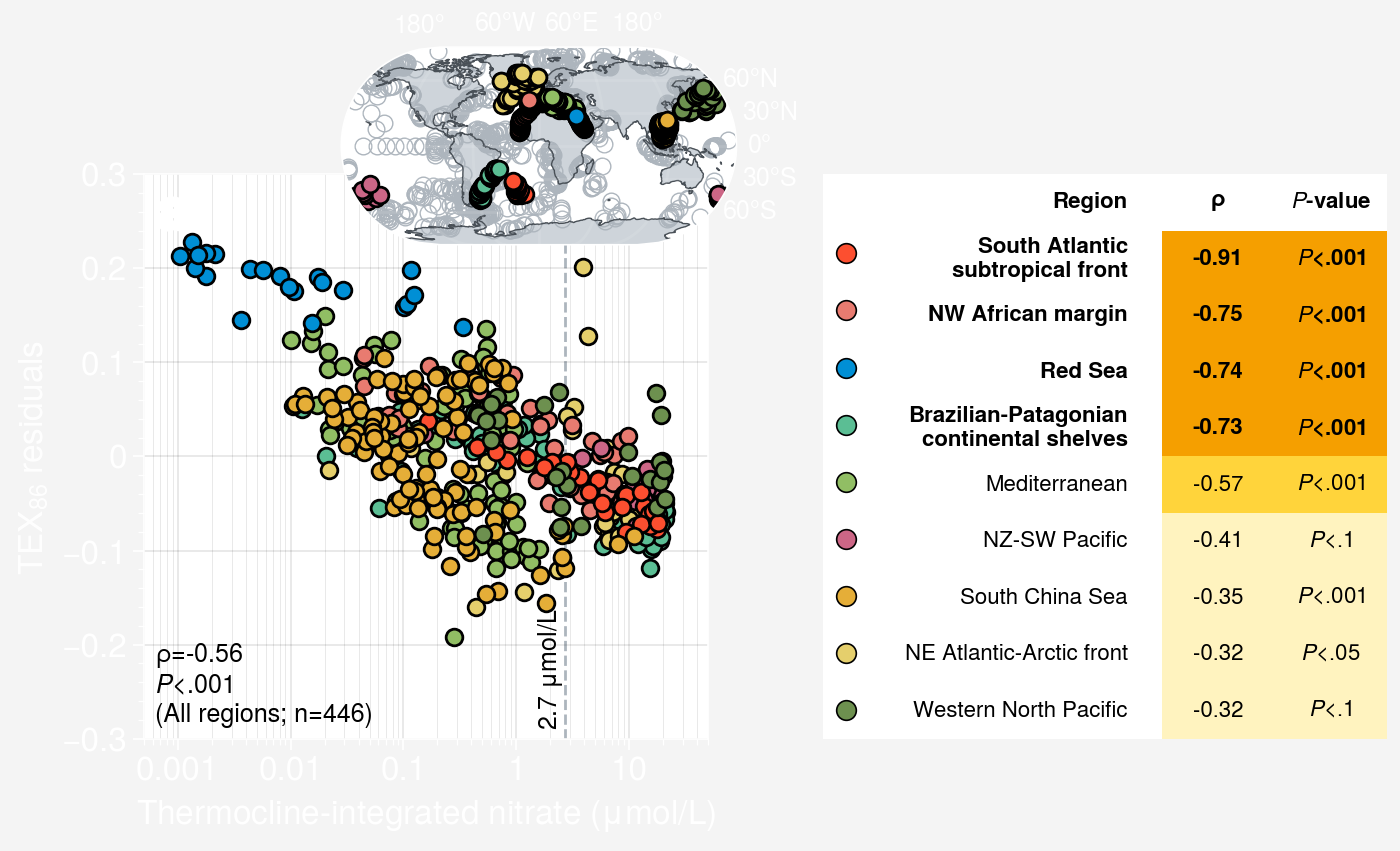

In [ ]:
plot.rc['meta.color'] = 'w'
cyc1 = plot.get_colors('qual1',N=5)
cyc2 = plot.get_colors('538',N=5)

sel_cyc = plot.Cycle(cyc1+cyc2)
### param for plotting
optimal_pval_cutoff = 0.1
nitrate_cutoff = 100

fig, axs = plot.subplots(ncols=2,
                         share=0,
                         width=7)
axs.format(fontsize=12)
plot_data = xr.merge([gridded_coretop_ds,t_sf2tc_da,thermocline_nitrate_da,coretop_gridded_d15N_ds])
plot_gridded_data = plot_data[['lat','lon','t_sf2tc_avg','no3_sf2tc_avg',
                                'tex_median','tex_residuals','tex_std',
                                'd15N_mean','region_ID']].to_dataframe().dropna(subset=['region_ID']).reset_index()
plot_gridded_data['regionName'] = plot_gridded_data['region_ID'].map(regionID_to_regionName_dict)
plot_gridded_data['regionName'] = plot_gridded_data['regionName'].replace({
    'Eastern Indian Ocean (Offshore Indonesia)' : 'Indonesian Offshore',
    'Northern Pacific':'Western North Pacific',
    'Eastern South America Offshore':'Brazilian-Patagonian\ncontinental shelves',
    'South Atlantic Gyre':'South Atlantic\nsubtropical front',
    'Tropical West African Offshore':'NW African margin',
    'North Atlantic':'NE Atlantic-Arctic front',
})

plot_gridded_data = plot_gridded_data[plot_gridded_data['no3_sf2tc_avg']<nitrate_cutoff]

# Create an inset axis overlapping on the top right corner of axs[0]
ax_inset = axs[0].inset_axes([0.35, 0.7, 0.7, 0.7],proj='eck3')

ax_inset.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='r', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray7',
        coastlinewidth=0.5,
        coastzorder=1,)
grouped = plot_gridded_data.groupby('regionName')

#### calculate rho and pval between tex_residuals and thermocl_depthIntg_nitrate by regions
rho_list = []
pval_list = []
region_name_list = []
for name, group in grouped:
    reg_data = group[['no3_sf2tc_avg', 'tex_residuals']].dropna()
    if len(reg_data) < 10:
        continue
    else:
        rho, pval = spearmanr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        rho_pearson, pval_pearson = pearsonr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        region_name_list.append(name)
        rho_list.append(rho)
        pval_list.append(pval)

### build a dataframe to sort by rho
rho_df = pd.DataFrame({'regionName': region_name_list,
                       'rho': rho_list,
                       'pval': pval_list})

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))]

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))][rho_df['regionName'].isin([
                           'Weddell Sea', 'Arctic Ocean', 'Drake Passage',
                           'Kara Sea', 'Greenland Sea',
                           'Laptev Sea',
                           'Sea of Okhotsk',
                        #    'Eastern South America Offshore_far'
                           ]) == False]
sig_regions_color_dict = dict(zip(sig_regions_['regionName'], plot.get_colors(sel_cyc, N=len(sig_regions_))))

for name, group in grouped:
    ### check rho and pval of each region
    if name not in sig_regions_['regionName'].unique():
        ax_inset.scatter(group['lon'], group['lat'],
                         c='none',
                         mec='gray5', mew=0.5,
                         label=name,
                         zorder=1)
    else:
        rho_ = rho_df[rho_df['regionName'] == name]['rho'].values[0]
        pval_ = rho_df[rho_df['regionName'] == name]['pval'].values[0]

        if (pval_ < optimal_pval_cutoff
            and (rho_ < 0)
            and name != 'Weddell Sea'
            and name != 'Arctic Ocean'
            and name != 'Drake Passage'
            and name != 'Kara Sea'
            and name != 'Greenland Sea'
            and name != 'Laptev Sea'
            and name != 'Sea of Okhotsk'
            # and name != 'Eastern South America Offshore_far'
            ):
            ax_inset.scatter(group['lon'], group['lat'],
                            #  cycle=sel_cyc,
                             c=sig_regions_color_dict.get(name, 'gray5'),
                             mec='k', mew=1,
                             label=name,
                             zorder=2)
            
ax = axs[0]
sig_plot_data = plot_gridded_data[plot_gridded_data['regionName'].isin(sig_regions_['regionName'])]
grouped = sig_plot_data.groupby('regionName')   
for name, group in grouped:
    ### plot data
    ax.scatter(group['no3_sf2tc_avg'],group['tex_residuals'],
                cycle=sel_cyc,
                mec='k',mew=1,
                label=name,
                zorder=2)
    
### add low-nitrate threshold
ax.axvline(lowno3_threshold,color='gray5',ls='--',lw=1,zorder=0)
### add vertical text 
x_pos = lowno3_threshold
y_pos = -0.29
ax.text(x_pos,y_pos,f'{lowno3_threshold:.1f} $\mu$mol/L',
        # transform=ax.get_xaxis_transform(),
        ha='right',va='bottom',
        rotation=90)
    
### ols regression of all significant regions
reg_data = sig_plot_data[['no3_sf2tc_avg','tex_residuals']].dropna()
reg_data['Log10_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
ols = LinearRegression()
XX = reg_data['Log10_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red')
### spearman rho and pval
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(All regions; n={len(reg_data)})',
        transform=ax.transAxes,
        ha='left',va='bottom')

### orthoganal distance regression 
X = reg_data['Log10_nitrate']
y = reg_data['tex_residuals']
covx = np.cov(X)
covy = np.cov(y)
odr_dat = scipy.odr.Data(X,y)
def linear_func(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
odr_func = scipy.odr.Model(linear_func)
odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[-2.,0.2])
out = odr.run()
slope = out.beta[0]
intercept = out.beta[1]
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = linear_func(out.beta,X_pred)
# ax.plot(10**X_pred,y_pred,c='k',ls='--',lw=2,label='ODR fit')

ax.format(
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
    xlim=(5e-4,5e1),
    xscale='log',
    xgridminor=True,
    ylim=(-0.3,0.3),
)


axs.format(
    abc='a',rc_kw={'abc.size':20},abcloc='ul',
)

### plot a table reporting rho and pval of significant regions
table_ax = axs[1]
table_ax.axis('off')
table_data = sig_regions_[['regionName','rho','pval']]

### formatted values to be displayed in the table as 4 significant figures
table_data['rho'] = table_data['rho'].apply(lambda x: f'{x:.2f}')
table_data['pval'] = table_data['pval'].apply(lambda x: f'{x:.4f}')
table_data['pval_labels'] = table_data['pval'].apply(lambda x: label_pvalues(float(x)))
table_data = table_data.rename(columns={'regionName':'Region',
                                        'rho':'$\\rho$',
                                        'pval_labels':r'$\it{P}$-value'})


table_data2 = table_data[['Region','$\\rho$',r'$\it{P}$-value']].sort_values(by='$\\rho$',ascending=False).copy()
### color cell with rho < -0.7
### set header text bold
### set header background color
# Define the number of rows and columns in the table
num_rows, num_cols = table_data2.shape

# Create a list for cell colors, keeping the first column (Region) white
cell_colors = [['white'] * num_cols for _ in range(num_rows)]

# Apply colors only to the second and third columns based on rho values
for i, rho in enumerate(table_data2['$\\rho$']):
    rho_value = float(rho)
    color = (
        'yellow7' if rho_value < -0.7 else 
        'yellow4' if rho_value < -0.5 else 
        'yellow1'
    )
    cell_colors[i][1] = color  # Apply color to the rho column
    cell_colors[i][2] = color  # Apply the same color to the p-value column

table = table_ax.table(cellText=table_data2.values,
                colLabels=table_data2.columns,
                loc='top',
                bbox=[0,0,1,1],
                colWidths=[0.6,0.2,0.2],
                cellColours=cell_colors,
                fontsize=12
                )

# Style table text
for (row, col), cell in table.get_celld().items():
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
    if col == 0:
        cell.get_text().set_ha('right')  # Align first column to the right
        if row > 0:
            region_name = table_data2.iloc[row-1]['Region'][2:]  
    else:
        cell.get_text().set_ha('center')
        if col == 1 and row > 0:
            if float(cell.get_text().get_text()) < -0.7:
                table[(row, 0)].get_text().set_fontweight('bold')
                table[(row, 1)].get_text().set_fontweight('bold')                
                table[(row, 2)].get_text().set_fontweight('bold')
    
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 1.5)
#change table line color to white
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Add colored markers manually using scatter()
num_rows = len(table_data2)
x_offset = -0.15  # Adjust this to position the circles
y_offset = np.linspace(0.86, 0.05, num_rows)  # Evenly space markers in the column

for i, region in enumerate(table_data2['Region']):
    color = sig_regions_color_dict.get(region, 'black')  # Default to black if not found
    table_ax.scatter(x_offset, y_offset[i], color=color, s=50, edgecolor='k', zorder=3)
    


table_ax.set_xlim(-0.2, 1)  # Adjust limits to ensure markers are visible
table_ax.set_ylim(0, 1)

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_regional_nitrate_effect_sig_regions_slides.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=1440)